# Lucerne and Pasture data cleaning
Soil water holding capacity is highly variable across short distances in alluvial soils such as the soil this trial was conducted on.  Replication helps to account for this variability but often there will still be differences in the mean absolute water content of treatments due to background soil variability and not due to the treatments them selves.  This creates difficulties for model optimisation where apparent model biases are actually due to this background variability.  To overcome this problem we conducted a bias analysis and correction in the observed data.  

What follows is anoted python code used to collate and graph the results from this analysis that is executable in a Jupyter notebook and may be used to reproduce this analysis if the data files are requested.

In [24]:
# Bring in the libraries we need
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.ticker as ticker
import GraphHelpers as GH
%matplotlib inline

In [22]:
# Bring in the cleaned observed data
TDRData = pd.read_pickle('.\DataFrames\LandPDailyTDR.pkl')
NPData = pd.read_pickle('.\DataFrames\\NeutronProbeVWC_df.pkl')

#Stick the data together into a single dataframe
Data = NPData.join(TDRData)

In [26]:
GPs = GH.SetGraphicsPatterns(Data.D7.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['red','blue','green','orange'])

Species
['Lucerne', 'Ryegrass']
Irrigation
['Dry', 'High', 'Low', 'Mid']
Treatments
MultiIndex(levels=[['Lucerne', 'Ryegrass'], ['Dry', 'High', 'Low', 'Mid']],
           labels=[[0, 0, 0, 0, 1, 1, 1, 1], [0, 1, 2, 3, 0, 1, 2, 3]])
Styles
[('-', 'red', 0.15, 'o'), ('-', 'blue', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'orange', 0.15, 'o'), ('--', 'red', 0.45, '^'), ('--', 'blue', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'orange', 0.45, '^')]
StyleFrame
              Lin     Col   Alp Mar     MFC
Lucerne  Dry    -     red  0.15   o     red
         High   -    blue  0.15   o    blue
         Low    -   green  0.15   o   green
         Mid    -  orange  0.15   o  orange
Ryegrass Dry   --     red  0.45   ^   white
         High  --    blue  0.45   ^   white
         Low   --   green  0.45   ^   white
         Mid   --  orange  0.45   ^   white


## First of all graph data to check we have what we expect

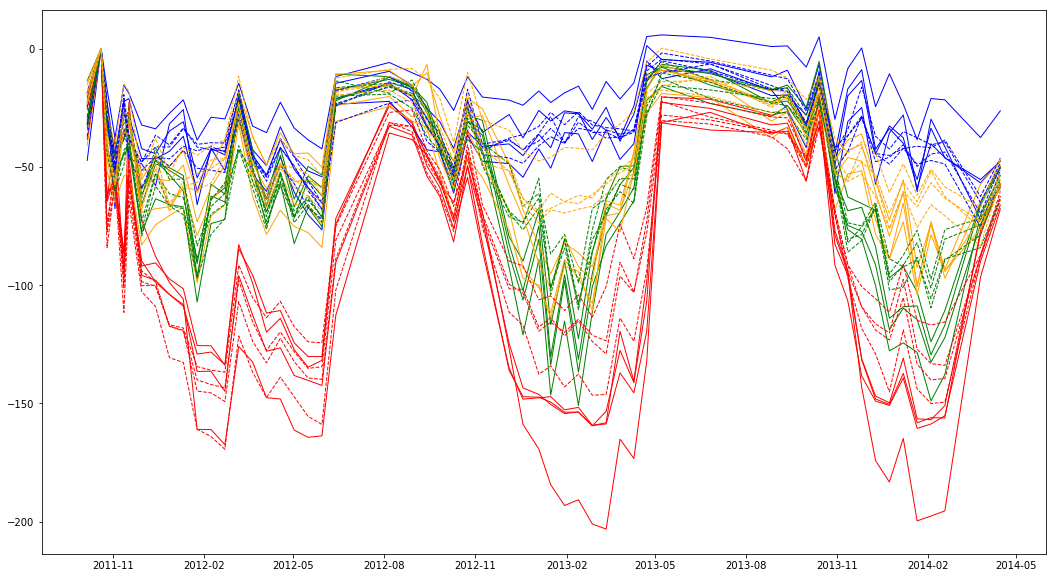

In [29]:
#Calculate the water content of the soil profile by multiplying the volumetric water content 
#by each layers depth and summing.  
ProfileWater = Data.loc[:,'D7'] * 150 + \
               Data.loc[:,'D23'] * 100 + \
               Data.loc[:,'D30'] * 100 + \
               Data.loc[:,'D50'] * 200 + \
               Data.loc[:,'D70'] * 200 + \
               Data.loc[:,'D90'] * 200 + \
               Data.loc[:,'D110'] * 200 + \
               Data.loc[:,'D130'] * 200 + \
               Data.loc[:,'D150'] * 200

                #Do some things to get the index tidy
ProfileWater.index = ProfileWater.index.normalize() # Need this step to remove hour values from dates
ProfileWater = ProfileWater.dropna(axis=0)      # This step removes all the dates where there were no measurements and nan were given

#Take field capacity as the water content on the 20th of October 2011
FieldCapacity = ProfileWater.loc['2011-10-20']   #Slicing a single date out of a data frame with date only format returns a multi indexed serise

#Calculate soil water deficit
SoilWaterDeficit = -(FieldCapacity - ProfileWater)  #This only works becaue FieldCapacity is a serise, not a dataframe
#and graph it
Fig = plt.figure(figsize=(18, 10))
ax = Fig.add_subplot(1,1,1)
GH.AddIndexedPlot(SoilWaterDeficit,ax,GPs,1)

# SoilWaterDeficit.plot(figsize=(18,10),style=['r-','b-','g-','y-','r--','b--','g--','y--'])
# plt.ylabel('Soil Water Deficit (mm)', fontsize=30);
# plt.tick_params(labelsize=25)
# plt.title('Lucerne and pasture Soil Water Deficits', fontsize=28);

In [18]:
Irrigation = pd.read_excel('.\RawDataFiles\Irrigation.xlsx')

In [19]:
Irrigation.set_index(['Irrigation','Date'],inplace=True)

In [20]:
Irrigation

Amount
Irrigation Date               
Dry        2013-02-28     20.0
High       2011-11-07     30.0
           2011-11-25     13.6
           2011-11-28     20.1
           2011-11-29     16.4
           2011-12-05     27.0
           2011-12-15      8.0
           2011-12-26     22.5
           2011-12-29     16.5
           2012-01-05     22.8
           2012-01-09     17.8
           2012-01-12      9.1
           2012-01-16     18.3
           2012-01-19     18.6
           2012-01-23     22.5
           2012-01-30      8.0
           2012-02-02     12.0
           2012-02-07     16.5
           2012-02-09     13.3
           2012-02-13     12.2
           2012-02-20     13.3
           2012-02-23      8.8
           2012-03-29     10.0
           2012-04-02      6.5
           2012-04-05      5.0
           2012-04-10      6.9
           2012-04-26      4.6
           2012-04-30      6.9
           2012-05-03      3.2
           2012-11-01     18.0
...                        ...
Mid        2014-01-16     40.9
           2014-01-30     35.0
           2014-02-13     25.0
           2014-02-27     32.0
Low        2011-11-07     30.0
           2011-11-29     47.6
           2011-12-15     34.9
           2011-12-29     41.8
           2012-01-12     49.8
           2012-01-26     36.8
           2012-02-09     49.6
           2012-02-23     34.3
           2012-04-05     21.4
           2012-05-03     23.7
           2012-11-01     18.0
           2012-11-22     12.0
           2012-12-13     27.0
           2013-01-03     42.0
           2013-01-24     45.0
           2013-02-14     90.6
           2013-02-28     20.0
           2013-03-07     30.0
           2013-03-28     18.0
           2013-04-18     15.0
           2013-10-24     12.0
           2013-11-14     33.0
           2013-12-05     36.0
           2014-01-16     44.7
           2014-02-05     33.5
           2014-02-27     32.0

[156 rows x 1 columns]

In [ ]:
ColIndex = pd.MultiIndex.from_product([('Ryegrass','Lucerne'),('Dry','Low','Mid','High'),(1,2,3,4)],names=['Species','Irrigation','Block'])
WaterUseNP = pd.DataFrame(index = ProfileWater.index,
    columns = ColIndex)
WaterUseNP.ix[:,:]=0
DeltaSWCFrame = WaterUseNP.copy()
IrrigationFrame = WaterUseNP.copy()
RainFallFrame = WaterUseNP.copy()
for plot in WaterUseNP.columns:
    for P in WaterUseNP.index:
        if P.strftime('%Y-%m-%d') == '2011-10-06':
            PrevPSWC = SoilWaterData.ix[(plot)].ix[P.strftime('%Y-%m-%d'),'ProfileWater'].values[0]
            PrevMeasureDate = '2011-10-06'
        else:
            #print(P.strftime('%Y-%m-%d'))
            DeltaSWC = PrevPSWC - SoilWaterData.ix[(plot)].ix[P.strftime('%Y-%m-%d'),'ProfileWater'].values[0]
            #print(DeltaSWC)
            DeltaSWCFrame.ix[P.strftime('%Y-%m-%d'),plot] = DeltaSWC
            Irrigation = Irrigations.ix[PrevMeasureDate,(plot[0],plot[1])]
            IrrigationFrame.ix[P.strftime('%Y-%m-%d'),plot] = Irrigation
            #print(Irrigation)
            Rainfall = Irrigations.ix[P.strftime('%Y-%m-%d'),('Field','Rain')]
            RainFallFrame.ix[P.strftime('%Y-%m-%d'),plot] = Rainfall
            #print(Rainfall)
            WU = DeltaSWC + Irrigation + Rainfall 
            #print(WU)
            WaterUseNP.ix[P.strftime('%Y-%m-%d'),plot] = WU
            PrevPSWC = SoilWaterData.ix[(plot)].ix[P.strftime('%Y-%m-%d'),'ProfileWater'].values[0]
            PrevMeasureDate = P.strftime('%Y-%m-%d')

In [30]:
ProfileWater.index

DatetimeIndex(['2011-10-06', '2011-10-20', '2011-10-26', '2011-11-03',
               '2011-11-12', '2011-11-17', '2011-11-30', '2011-12-14',
               '2011-12-28', '2012-01-11', '2012-01-25', '2012-02-08',
               '2012-02-22', '2012-03-07', '2012-03-21', '2012-04-04',
               '2012-04-18', '2012-05-02', '2012-05-16', '2012-05-30',
               '2012-06-13', '2012-08-06', '2012-08-29', '2012-09-13',
               '2012-09-26', '2012-10-10', '2012-10-24', '2012-11-08',
               '2012-12-05', '2012-12-19', '2013-01-04', '2013-01-16',
               '2013-01-30', '2013-02-13', '2013-02-27', '2013-03-13',
               '2013-03-27', '2013-04-10', '2013-04-23', '2013-05-08',
               '2013-06-26', '2013-08-27', '2013-09-12', '2013-10-01',
               '2013-10-14', '2013-10-30', '2013-11-12', '2013-11-26',
               '2013-12-10', '2013-12-24', '2014-01-07', '2014-01-21',
               '2014-02-04', '2014-02-18', '2014-03-26', '2014-04-15'],
     